# Heating a rod

A general heat equation for one-dimensional system is given by

$$
c_p \rho \frac{\partial T}{\partial t} = \kappa \frac{\partial^2 T}{\partial x^2} + q_\text{loss}
$$

where $c_p$, $\rho$, and $\kappa$ are specific heat capacity, mass density and heat conductivity, respectively. We also take into account the loss of heat to the environment by $q_\text{loss}$. When the system is in a steady state ($\partial T/\partial t = 0$), this partial differential equation becomes a ODE

$$
\kappa \frac{d^2 T}{d x^2} = - q_\text{loss}
$$

Now, we consider a long metallic rod of length $L$ placed in a thermal environment.  The temperature of the environment is kept at $T_0$.
Then, each end of the rod is attached to thermostat so that the temperature of the left end is kept at $T_L>T_0$ and the right end at $T_R >T_0$  As the temperature of the rod is higher than the environment, heat energy dissipate into the environment by

$$
q_\text{loss} = - \mu (T(x) - T_0)
$$(eq:loss_linear)

where $\mu$ is a positive constant. This model is valid only when $|T-T_0|$ is small.

Now we calculate the temperature profile in the rod.   It is convenient to use a temperature measured from $T_0$.  Introducing, $u=T-T_0$ and normalized length, $s=x/L$,  the ODE is simplified to

$$
\frac{d ^2}{d s^2} u(s) = \gamma u(s)
$$(eq:heating_rod)

where $\gamma = \mu L^2/\kappa$ is a dimensionless constant. Letting $w(x)=-\gamma$ and $S(x)=0$, this ODE can be integrated by the Numerov method.


Finally, we want to make it sure that the solution is accurate enough to compute other physical quantities.  As an example, we check the conservation of energy.  In the current setting, energy is injected from the left end of the rod. Its magnitude is determined by the temperature gradient:

$$
Q_\text{in} = -\kappa T'(0) \quad \rightarrow \quad - u'(0)
$$

where the last expression is for dimensionless calculation.  Similarly energy loss from the right end is

$$
Q_\text{out} = +\kappa T'(L)\quad \rightarrow \quad + u'(1) 
$$

and the heat dissipation through the surface of the rod is given by

$$
Q_\text{diss} = - \mu \int_0^L [T(x)-T_0] dx \quad \rightarrow \quad - \gamma \int_0^1 u(s) ds
$$

Since the net energy transaction must be balanced, $Q_\text{in}+Q_\text{out}+Q_\text{diss} =0$.  

The following code calculates the temperature profile using the Numerov method and evaluates the energy transaction. Now, pick parameter values.  All constants ($\mu, L, \kappa$) are combined together into one parameter $\gamma$ and thus we don't have to specify each parameter value.  We use $\gamma=10$ in the example calculation.   The example boundary conditions are $u(0)=1$ and $u(1)=0$. It is not necessary to compute other value of $u(0)$ because Eq. {eq}`eq:heating_rod` is linear.  If $u(x)$ is a solution, $c\, u(x)$ is also a solution.  If you change the temperature at the left end as $T_L=100$, the solution would be $100 u(x)$. There is no need to recalculate the solution.
If the heat loss is not linear to the temperature difference, we cannot use this trick. (See Problem 5.1.) 

The temperature profile is plotted in the left panel of Fig \ref{fig:heating_rod}. When the temperature is high, heat dissipation is faster and thus temperature gradient is larger near the left edge. If the heat dissipation to the environment is not considered, the profile is a straight line from $T_L$ to $T_R$. The effect of the dissipation is clearly visible in the plot. The right panel shows the error after each iteration. The improvement is not very fast but steady.  Here is the output of the energy transaction:


Q_in= 31.731307,  Q_out=-31.294434,  Q_diss= -0.436942,  Q_net= -0.000069


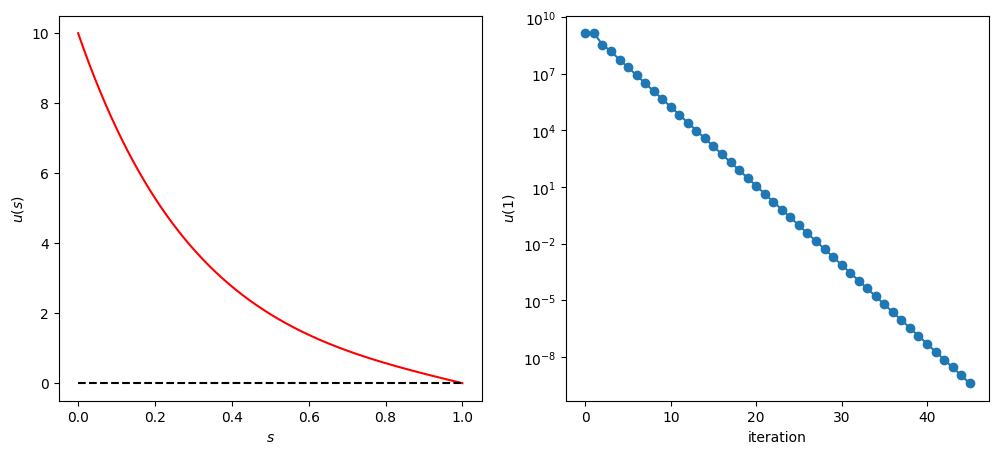

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def numerov_heat(TL,delta,L):
    global mu
    # control parameters
    N=10000; h=L/N
    x=np.linspace(0,L,N+1)
    u=np.zeros(N+1)

    # define w(x) in Numerov method
    w=mu

    # initial conditions
    u[0]=TL

    # we guess u(h)
    u[1]=u[0]-delta

    # shoot out to x=L by the Numerov method
    for n in range(1,N):
        u[n+1] = 2.0*(1.0-5.0*h**2*w/12.0)*u[n] - (1.0+h**2*w/12.0)*u[n-1]
        u[n+1] = u[n+1]/(1+h**2*w/12.0)
        
    return [x,u]
       
# parameters
global mu
mu = -10.0
TL=10.0;  TR=0.0; L=1.0
        
# tolerance
tol=1.0e-9
        
# control variable 
found = False

y1 = np.zeros(1000)
y2 = np.zeros(1000)
# first guess of delta
y1[0] = 1
# get the u(x)
[x, u] = numerov_heat(TL,y1[0],L)
N = u.size-1   # check how many grid points are used.
y2[0]=(u[N]-TR)**2
if abs(y2[0]) < tol:
    found = True

if not(found):
    #second guess of delta
    y1[1] = y1[0]+0.01
    # get u(x)
    [x,u] = numerov_heat(TL,y1[1],L)
    y2[1] =(u[N]-TR)**2
    if abs(y2[1]) < tol:
        found = True

# secant iteration
n=1
while not(found):
    # guess delta by secant method
    y1[n+1] = y1[n] - (y1[n]-y1[n-1])/(y2[n]-y2[n-1])*y2[n]
    # derivative of phi(x) at the end point.
    [x,u] = numerov_heat(TL,y1[n+1],L)
    y2[n+1]=(u[N]-TR)**2
    if abs(y2[n+1]) < tol:
        found = True

    n+=1


# Energy conservation
Q_in = -(u[1]-u[0])/(x[1]-x[0])
Q_out= +(u[n]-u[n-1])/(x[n]-x[n-1])
Q_diss = mu*sum(u[0:n-1:2]+4.0*u[1:n:2]+u[2:n+1:2])*(x[1]-x[0])/3.0
print('Q_in={0:10.6f},  Q_out={1:10.6f},  Q_diss={2:10.6f},  Q_net={3:10.6f}'
        .format(Q_in, Q_out, Q_diss, Q_in+Q_out+Q_diss))

# plot heat source
plt.ioff()
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(x,u,'-r')
plt.plot([0,L],[0,0],'--k')
plt.xlabel(r'$s$')
plt.ylabel(r'$u(s)$')

plt.subplot(1,2,2)
# plot the error after each iteration.
plt.semilogy(np.linspace(0,n,n+1),abs(y2[0:n+1]),'-o')
plt.xlabel('iteration')
plt.ylabel(r'$u(1)$')

plt.show()
